In [1]:
import scipy
import numpy as np
import scipy.integrate
import scipy.optimize
import scipy.interpolate

import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

from IPython.display import display

%config InlineBackend.figure_format = 'retina'

style.use("seaborn-bright")

## Cross Current Heat Exchanger

Hot side
$$
        \frac{dH^H}{dz} = - \frac{UP}{m_H} (T_H - T_C)
$$

Cold side
$$
        \frac{dH^C}{dz} = - \frac{UP}{m_C} (T_H - T_C)
$$

Boundary Conditions
$$
        T_H|_{(z=0)} = T_H^{in} ;   T_C|_{(z=L)} = T_C^{in}
$$

In [2]:
def H_H(T): #T in K
    H = 4184.0 * T + 41.84*np.log(T)
    return H
    
def H_C(T): # T in K
    H = 2430.0 * T + 24.30*np.log(T)
    return H

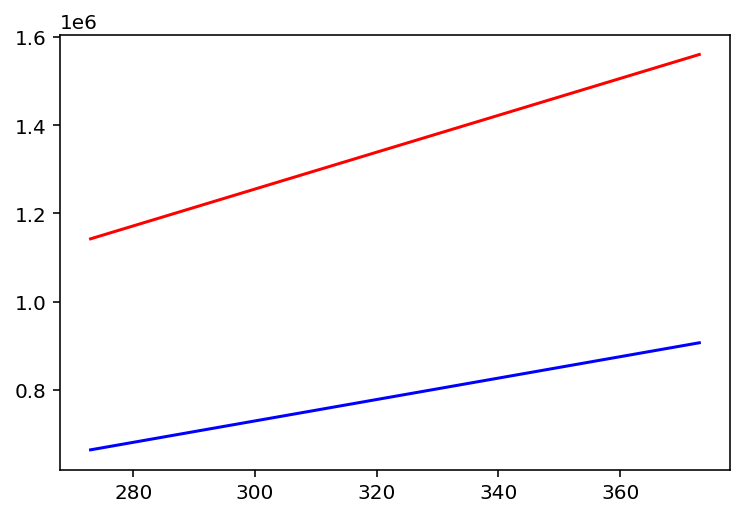

In [3]:
T = np.linspace(273.0, 373.0, 100)
plt.plot(T, H_H(T), 'r')
plt.plot(T, H_C(T), 'b')

In [4]:
T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)
    

In [5]:
def model(SV, z, heatx):
    [H_H, H_C] = SV
    
    U = heatx.U
    P = heatx.P
    mH = heatx.mH
    mC = heatx.mC
    
    T_H = heatx.T_H(H_H)
    T_C = heatx.T_C(H_C)
    
    dH_Hbydz = -U*P/mH * (T_H - T_C)
    dH_Cbydz = -U*P/mC * (T_H - T_C)
    
    return [dH_Hbydz, dH_Cbydz]

In [6]:
def shoot(T_Cout, heatx):
    heatx.T_Cout = T_Cout

    SV0 = [H_H(heatx.T_Hin), H_C(heatx.T_Cout)]
    z = [0, heatx.L]
    solution = scipy.integrate.odeint(
                                        model,
                                        SV0,
                                        z,
                                        args = (heatx,)
    )
    H_Cin = solution[-1, 1]
    T_Cin = heatx.T_C(H_Cin)

    error = [T_Cin - heatx.T_Cin]
    return error


class HeatX:
    def __init__(self):
        self.U = 400.0 #W/m2-K
        self.P = 0.1 #m2/m
        self.L = 2.0 #m
        
        self.mH = 0.01 #kg/s
        self.mC = 0.01 #kg/s
        self.T_Hin = 373.16 #K
        self.T_Cin = 303.16 #K
    
    def initialize(self):
        T = np.linspace(self.T_Cin, self.T_Hin, 1000)
        self.T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
        self.T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)
    
    def solve(self, n = 100):
        
        self.initialize()
        
        guess = [self.T_Cin + 0.0]
        
        lsq = scipy.optimize.least_squares(shoot, guess, args = (self,))
        
        SV0 = [H_H(self.T_Hin), H_C(self.T_Cout)]
        z = np.linspace(0,self.L, n)
        solution = scipy.integrate.odeint(
                                        model,
                                        SV0,
                                        z,
                                        args = (self,)
        )
        H_Hsol = solution[:,0]
        H_Csol = solution[:,1]
        self.delT_in = self.T_H(H_Hsol[0]) - self.T_C(H_Csol[0])
        self.delT_out = self.T_H(H_Hsol[-1]) - self.T_C(H_Csol[-1])
        self.lmtd = (self.delT_in-self.delT_out)/np.log(self.delT_in/self.delT_out)
        self.solutiondf = pd.DataFrame({
                                    "z":z,
                                    "T_H":self.T_H(H_Hsol),
                                    "T_C":self.T_C(H_Csol)
        })
        
        
    def heatx_plots(self):
        solutiondf = self.solutiondf
        ax = plt.figure()
        plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_H, 'r', label="Hot fluid side")
        plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_C, 'b', label="Cold fluid side")
        plt.legend()
        plt.xlabel("Length axis (z=0 to z= %.1f m)" %(self.L))
        plt.ylabel("Temperature (K)")
        plt.grid()
        #plt.xlim([0, self.L])
        #plt.ylim([300, 380])
        textstr =("Temp Difference (K)\n"+ 
                 "@(z=0): %.1f\n" %(self.delT_in)+ 
                 "@(z=%.1f): %.1f\n" %(self.L, self.delT_out)+
                 "LMTD: %.1f" %(self.lmtd))
        props = dict(boxstyle='round', facecolor='beige', alpha=0.5)
        ax.text(0.2, 0.35, textstr, fontsize=10,
        verticalalignment='top', bbox=props);

            
        
        


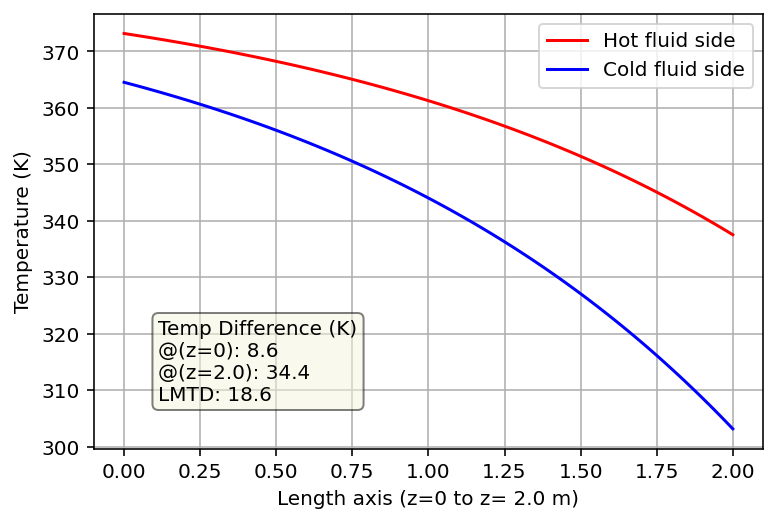

In [7]:
heatx = HeatX()
heatx.solve()
heatx.heatx_plots()